In [1]:
%load_ext autoreload
%autoreload 2

# avoid GPU due to Cholesky decompositions
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
sess = tf.InteractiveSession()

import numpy as np
from utils import gen_data, plot_model, eval_model
from npde_helper import build_model, fit_model, save_model, load_model

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.






## Collaborative Active Learning

### Helper

In [50]:
def IG_sum(de_model, X, Ts, sn, prior_logdets, betas):
    return sum(_IG(de_model, X, T, sn, prior_logdet) *1.0 / beta for T, prior_logdet, beta in zip(Ts, prior_logdets, betas) )

def get_covariance_full(de_model, X, T, sn):
    KTT = de_model.kern._vectorK(T, T)
    
    KTX = de_model.kern._vectorK(T, X)
    
    sigma_matrix = tf.diag(sn).eval()
    I_for_X = tf.eye(int(X.shape[0])).eval()
    tilde_KXX = de_model.kern._vectorK(X, X) + np.kron(sigma_matrix, I_for_X)
    
    return (KTT - KTX @ tf.linalg.inv(tilde_KXX) @ tf.transpose(KTX)).eval()


def _IG(de_model, X, T, sn, prior_logdet, jitter=1e-7):
    post_cov = get_covariance_full(de_model, X, T, sn)
    _, post_logdet = np.linalg.slogdet(post_cov + np.eye(post_cov.shape[0])*jitter)

    return 0.5* (prior_logdet - post_logdet)

    
def entropy_sum(de_model, acquired_obs, Ts, sn, betas=[]):
    if len(betas) == 0:
        betas = np.ones(len(Ts)) / len(Ts)
    else:
        betas = np.asarray(betas)
    
    return sum(_entropy(de_model, acquired_obs, T, sn) *1.0 / beta for T, beta in zip(Ts, betas) )

def _entropy(de_model, acquired_obs, T, sn, exact=False, jitter=1e-7):
    '''
    Note this is not the exact differential entropy formula, 
    instead it ignores some constant terms including the dimension d of data.
    
    For the purpose of maximum entropy search, it is sufficient since we only need the rank and not the 
    absolute value of entropy.
    '''
    post_cov = get_covariance_full(de_model, acquired_obs, T, sn)
    _ , post_logdet = np.linalg.slogdet(post_cov + np.eye(post_cov.shape[0])* jitter )

    if not exact:        
        return post_logdet    
    else:
        d = len(acquired_obs[0])
        differential_entropy = 0.5 * post_logdet + d /2.0 * np.log(2 * np.pi * np.exp(1))
        
        return differential_entropy

### Implementation and execution

In [57]:
def coordinated_greedy(de_model, Ss, Ts, budget, prior_logdets, subset_size=1000, betas=[], d=2, sn=[]):
    if len(betas) == 0:
        betas = np.ones(len(Ts)) / len(Ts)
    else:
        assert len(betas) == len(Ts)
        betas = np.asarray(betas) / sum(betas)
        
    acquired_obs = np.asarray([]).reshape(-1, d)
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Supports = deepcopy(Ss)

    if len(sn) == 0:
        sn = de_model.sn
    
    for _ in range(budget):
        delta_IG_max = -float('inf')
        obs_ = None
        prev_IG = 0

        full_cartesian = np.asarray(list(product(*Supports)))
        subset_size = min(subset_size, len(full_cartesian))

        subset_cartesian = full_cartesian[np.random.choice(len(full_cartesian), size=subset_size, replace=False)]
        for obs in subset_cartesian:
            temp_obs = np.append(acquired_obs, [obs]).reshape(-1, d)

            delta_IG = IG_sum(de_model, temp_obs, Ts, sn, prior_logdets, betas) - prev_IG
            # the weighted sum of difference in IG_k - IG_{k-1} in Equation (2)

            if delta_IG > delta_IG_max:
                delta_IG_max = delta_IG
                obs_ = obs

#         print("budget: {}".format(_), IG_max, obs_)
        acquired_obs = np.append(acquired_obs, [obs_]).reshape(-1, d)
        
        prev_IG = IG_sum(de_model, acquired_obs, Ts, sn, prior_logdets, betas)
        
        for i, (S, ob) in enumerate(zip(Supports, obs_)):
            Supports[i] = S[S != ob].reshape(-1, d)

    return acquired_obs

def coordinated_joint(de_model, Ss, joint_target, budget, prior_logdet_joint, subset_size=1000, d=2, sn=[]):
    acquired_obs = np.asarray([]).reshape(-1, d)
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Supports = deepcopy(Ss)
    
    if len(sn) == 0:
        sn = de_model.sn
    
    for _ in range(budget):
        delta_IG_max = -float('inf')
        obs_ = None
        prev_IG = 0

        full_cartesian = np.asarray(list(product(*Supports)))
        subset_size = min(subset_size, len(full_cartesian))

        subset_cartesian = full_cartesian[np.random.choice(len(full_cartesian), size=subset_size, replace=False)]
              
        for obs in subset_cartesian:
            temp_obs = np.append(acquired_obs, [obs]).reshape(-1, d)
            
            delta_IG = _IG(de_model, temp_obs, joint_target, sn, prior_logdet_joint) - prev_IG
            
            if delta_IG > delta_IG_max:
                delta_IG_max = delta_IG
                obs_ = obs
        
        acquired_obs = np.append(acquired_obs, [obs_]).reshape(-1, d)                
        
        prev_IG = _IG(de_model, acquired_obs, joint_target, sn, prior_logdet_joint)

        for i, (S, ob) in enumerate(zip(Supports, obs_)):
            Supports[i] = S[S != ob].reshape(-1, d)

    return acquired_obs


def coordinated_random(Ss, Ts, budget, prior_logdets, d=2):
    acquired_obs = np.asarray([]).reshape(-1, d)
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Supports = deepcopy(Ss)
    
    for _ in range(budget):

        full_cartesian = np.asarray(list(product(*Supports)))
        
        obs_ = full_cartesian[np.random.choice(len(full_cartesian), size=1, replace=False)].squeeze()
        acquired_obs = np.append(acquired_obs, [obs_]).reshape(-1, d)

        for i, (S, ob) in enumerate(zip(Supports, obs_)):
            Supports[i] = S[S != ob].reshape(-1, d)

    return acquired_obs

def coordinated_entropy(de_model, Ss, Ts, budget, subset_size=1000, d=2, sn=[]):
    acquired_obs = np.asarray([]).reshape(-1, d)
    
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Supports = deepcopy(Ss)
    
    if len(sn) == 0:
        sn = de_model.sn

    for _ in range(budget):
        obs_ = None
        
        entropy_max = -float('inf')

        full_cartesian = np.asarray(list(product(*Supports)))
        subset_size = min(subset_size, len(full_cartesian))

        subset_cartesian = full_cartesian[np.random.choice(len(full_cartesian), size=subset_size, replace=False)]

        for obs in subset_cartesian:
            temp_obs = np.append(acquired_obs, [obs]).reshape(-1, d)

            curr_entropy = entropy_sum(de_model, temp_obs, Ts, sn)
            
            if curr_entropy > entropy_max:
                entropy_max = curr_entropy
                obs_ = obs

#         print("budget: {}".format(_), IG_max, obs_)
        acquired_obs = np.append(acquired_obs, [obs_]).reshape(-1, d)
        
        for i, (S, ob) in enumerate(zip(Supports, obs_)):
            Supports[i] = S[S != ob].reshape(-1, d)

    return acquired_obs

def individual_greedy(de_model, S, T, prior_logdet, budget, d=2, subset_size=1000, sn=[]):
        
    acquired_obs = np.asarray([]).reshape(-1, d)
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    if len(sn) == 0:
        sn = de_model.sn
    
    Support = (S)
    IG_trail = []
    for _ in range(budget):
        delta_IG_max = -float('inf')
        obs_ = None
        prev_IG = 0
        
        subset_size = min(subset_size, len(Support))
        sub_support = Support[np.random.choice(len(Support), size=subset_size, replace=False)]
        for obs in sub_support:        
            temp_obs = np.append(acquired_obs, [obs]).reshape(-1, d)

            delta_IG = _IG(de_model, temp_obs, T, sn, prior_logdet) - prev_IG

            if delta_IG > delta_IG_max:
                delta_IG_max = delta_IG
                obs_ = obs

        IG_trail.append(delta_IG_max)
        acquired_obs = np.append(acquired_obs, [obs_]).reshape(-1, d)
        prev_IG = _IG(de_model, acquired_obs, T, sn, prior_logdet)

        Support = S[S!= obs_].reshape(-1,d)

    return acquired_obs, IG_trail


def coordinated_greedy_IG_sum(de_model, Ss, Ts, budget, prior_logdets, subset_size=1000, betas=[], d=2, sn=[]):
    '''
    Greedily maximizing the total sum of IGs in coordination instead of the marginal to the total sum of IGs 
    as in coordinated_greedy().
    
    This method does NOT satisfy near-optimality guarantee but may help with "cumulative" fairness of overall
    IGs.
    
    '''
    betas = _check_betas(n=len(Ts), betas=betas)

    acquired_obs = np.asarray([]).reshape(-1, d)
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Supports = deepcopy(Ss)

    if len(sn) == 0:
        sn = de_model.sn
    
    for _ in range(budget):
        IG_sum_max = -float('inf')
        obs_ = None

        full_cartesian = np.asarray(list(product(*Supports)))
        subset_size = min(subset_size, len(full_cartesian))

        subset_cartesian = full_cartesian[np.random.choice(len(full_cartesian), size=subset_size, replace=False)]
        for obs in subset_cartesian:
            temp_obs = np.append(acquired_obs, [obs]).reshape(-1, d)

            IG_sum_curr = IG_sum(de_model, temp_obs, Ts, sn, prior_logdets, betas)
            # Directly try to maximize the total sum of IGs
            
            if IG_sum_curr > IG_sum_max:
                IG_sum_max = IG_sum_curr
                obs_ = obs

#         print("budget: {}".format(_), IG_max, obs_)
        acquired_obs = np.append(acquired_obs, [obs_]).reshape(-1, d)
                
        for i, (S, ob) in enumerate(zip(Supports, obs_)):
            Supports[i] = S[S != ob].reshape(-1, d)

    return acquired_obs


from scipy.special import softmax
def coordinated_dynamic_beta(de_model, Ss, Ts, budget, prior_logdets, subset_size=1000, betas=[], beta_coef=0.5, d=1, sn=[]):
    '''
    The beta values are dynamically updated according to the latest IGs of the agents to help improve
    "cumulative" fairness.

    '''
    betas = _check_betas(n=len(Ts), betas=betas)

    acquired_obs = np.asarray([]).reshape(-1, d)
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Supports = deepcopy(Ss)

    if len(sn) == 0:
        sn = de_model.sn
    
    
    for _ in range(budget):
        IG_sum_max = -float('inf')
        obs_ = None

        full_cartesian = np.asarray(list(product(*Supports)))
        subset_size = min(subset_size, len(full_cartesian))

        subset_cartesian = full_cartesian[np.random.choice(len(full_cartesian), size=subset_size, replace=False)]
        for obs in subset_cartesian:
            temp_obs = np.append(acquired_obs, [obs]).reshape(-1, d)

            IG_sum_curr = IG_sum(de_model, temp_obs, Ts, sn, prior_logdets, betas)
            # Directly try to maximize the total sum of IGs
            
            if IG_sum_curr > IG_sum_max:
                IG_sum_max = IG_sum_curr
                obs_ = obs

        acquired_obs = np.append(acquired_obs, [obs_]).reshape(-1, d)

        individual_IGs = [_IG(de_model, acquired_obs, T, sn, prior_logdet) for T, prior_logdet in zip(Ts, prior_logdets) ]
        
        updated_betas = softmax(individual_IGs)
        betas = beta_coef * betas + (1-beta_coef) * updated_betas
    
        for i, (S, ob) in enumerate(zip(Supports, obs_)):
            Supports[i] = S[S != ob].reshape(-1, d)

    return acquired_obs

def _check_betas(n, betas=[]):
    if len(betas) == 0:
        betas = np.ones(n) / n
    else:
        assert len(betas) == n
        betas = np.asarray(betas) / sum(betas)
    return betas

## 1 ODE

### Data Generation

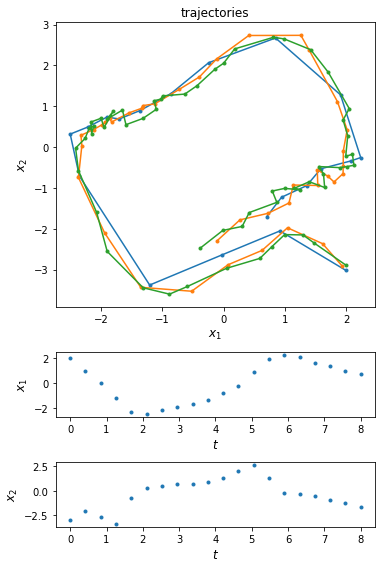

In [9]:
np.random.seed(918273) # just for illustration purposes
x0,t,Y,X,D,f,g = gen_data('vdp', Ny=[20,40,60], tbegin=0, tend=8, nstd=0.1)

Model being initialized...



Prior noise variances are [0.5 0.5].
Building loss function...

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all referen

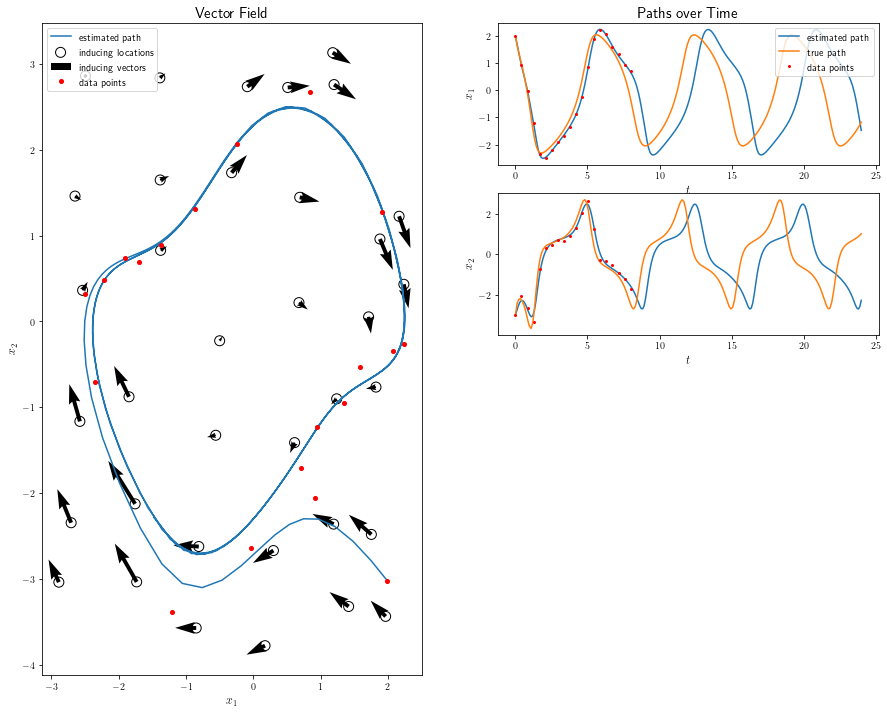

Posterior noise variances are [0.00321101 0.03564574].


In [10]:
# t - observation times, a python array of numpy vectors
# Y - observations, a python array of numpy matrices, data points are in rows
# step size (eta) must be carefully tuned for different data sets
npde = build_model(sess, t, Y, model='ode', sf0=1.0, ell0=np.ones(2), W=6, ktype="id")

prior_sn = npde.sn.eval()
print(f'Prior noise variances are {prior_sn}.')

npde = fit_model(sess, npde, t, Y, num_iter=500, print_every=50, eta=0.02, plot_=True)

posterior_sn = npde.sn.eval()
print(f'Posterior noise variances are {posterior_sn}.')


# how to plot the model
# plot_model(npde,t,Y)

# how to save/load the model
# save_model(npde,'npde.pkl')
# npde = load_model('npde.pkl',sess)

# eval_t = [np.linspace(0, 8, 50)]
# eval_model(npde, eval_t, Y, Nw=1)

#### Evaluate the model over full domain

eval_model(npde, t, Y, Nw=1)

#### Evaluate the model over a restricted domain (0, 4)

In [11]:
eval_t = [np.linspace(0, 4, 50)]
eval_model(npde, eval_t, Y, Nw=1)

name:                  npode
noise variance:        [0.00321101 0.03564574]
signal variance:       1.6252644328288437
lengthscales:          [0.83036801 1.17278947]
RMSE over the dimensions is: 3.419558887225632


3.419558887225632

#### Define target(s) and supports by splitting the generated Y

__Split the Y into the supports of the agents__

In [ ]:
plt.figure(figsize=(8, 6))

plt.scatter(Y[2][:30][:,0], Y[2][:30][:,1])
plt.scatter(Y[2][30:][:,0], Y[2][30:][:,1])

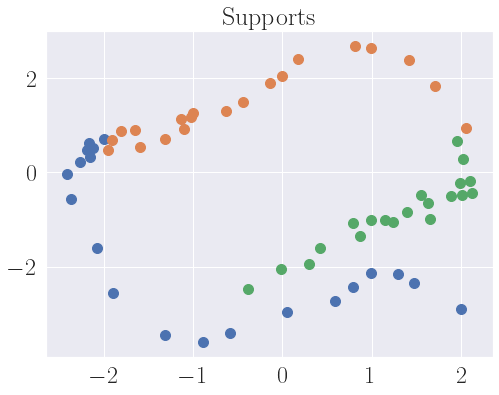

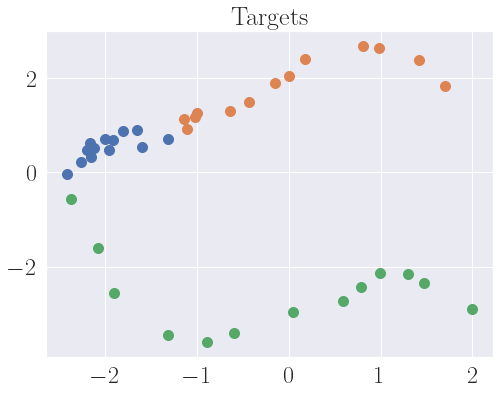

In [170]:
import numpy as np
rng = np.random.RandomState(0)

from copy import deepcopy
from itertools import product


d = 2 # dimension of data
n = 3 # total number of agents

budget = 10

# select the index of the generated trajectories
trajectory_index = 2

trajectory = Y[trajectory_index]
time = t[trajectory_index]

trajectory_length = len(trajectory)
assert len(time) == trajectory_length, "Check the trajectory index or the Y,t."


Ts, Ss = [], []
mt, ms = int(trajectory_length // 4.5), trajectory_length // 3
times = []

for i in range(n):

    S = trajectory[i*ms:(i+1)*ms]
    Ss.append(S)
    
    individual_time = time[i*ms:(i+1)*ms]
    times.append(individual_time)
    
    shifted_i = (i+1) % (n)    
    
    T = trajectory[shifted_i*mt:(shifted_i+1)*mt]
    Ts.append(T)

plt.figure(figsize=(8, 6))

for S in Ss:    
    plt.scatter(S[:,0], S[:,1])
plt.title('Supports')
    
plt.figure(figsize=(8, 6))
for T in Ts:    
    plt.scatter(T[:,0], T[:,1])
plt.title('Targets')

target_supports = {'Ts':Ts, 'Ss':Ss}

In [171]:
prior_logdets, prior_covs = [], []

de_model = npde
jitter = 1e-7

for T in Ts:
    prior_cov = get_covariance_full(de_model, T, T, prior_sn)
    _, logdet = np.linalg.slogdet(prior_cov + np.eye(prior_cov.shape[0]) * jitter )
    prior_covs.append(prior_cov)
    prior_logdets.append(logdet)
prior_logdets

[-299.9279269276342, -262.90372336439975, -240.9183837992451]

In [172]:
joint_target = np.unique(np.concatenate(Ts), axis=0)
    
prior_cov_joint = get_covariance_full(de_model, joint_target, joint_target, prior_sn)
_, prior_logdet_joint = np.linalg.slogdet(prior_cov+ np.eye(prior_cov.shape[0]) * jitter)

In [45]:
prior_logdet_joint

-434.3779026970045

In [173]:
# from favoring the first to uniform
greedy_obs_1 = coordinated_greedy(de_model, Ss, Ts, budget, prior_logdets, 
                                  subset_size=5, betas=[10,5,1], d=d, sn=posterior_sn)

In [174]:
greedy_obs_2 = coordinated_greedy(de_model, Ss, Ts, budget, prior_logdets, 
                                  subset_size=5, betas=[10,2,1], d=d, sn=posterior_sn)
greedy_obs_3 = coordinated_greedy(de_model, Ss, Ts, budget, prior_logdets, 
                                  subset_size=5, betas=[10,1,1], d=d, sn=posterior_sn)
greedy_obs_4 = coordinated_greedy(de_model, Ss, Ts, budget, prior_logdets, 
                                  subset_size=5, d=d, sn=posterior_sn)

In [175]:
joint_obs = coordinated_joint(de_model, Ss, joint_target, budget, prior_logdet_joint, subset_size=5, d=d, sn=posterior_sn)

In [176]:
rand_obs = coordinated_random(Ss, Ts, budget, prior_logdets, d=d)

In [177]:
entropy_obs = coordinated_entropy(de_model, Ss, Ts, budget, subset_size=5, d=d, sn=posterior_sn)

In [178]:
greedy_sum_obs = coordinated_greedy_IG_sum(de_model, Ss, Ts, budget, prior_logdets, subset_size=5, betas=[], d=d, sn=posterior_sn)

In [179]:
dynamic_beta_obs = coordinated_dynamic_beta(de_model, Ss, Ts, budget, prior_logdets, subset_size=5, betas=[], beta_coef=0.2, d=d, sn=posterior_sn)

In [180]:
indiv_greedy_obs,  ind_greedy_IG_trails = [], []
for i in range(n):
    ind_greedy_ob, ind_greedy_IG_trail= individual_greedy(de_model, Ss[i], Ts[i], prior_logdets[i], 
                                                          budget, d=d, subset_size=5, sn=posterior_sn)
    indiv_greedy_obs.append(ind_greedy_ob)
    ind_greedy_IG_trails.append(ind_greedy_IG_trail)

In [181]:
obs_ode = {'greedy_obs_1': greedy_obs_1, 'greedy_obs_2': greedy_obs_2, 'greedy_obs_3': greedy_obs_3,
          'greedy_obs_4': greedy_obs_4, 
          'greedy_sum_obs': greedy_sum_obs, 'dynamic_beta_obs':dynamic_beta_obs,
          'joint_obs': joint_obs, 'rand_obs': rand_obs, 'entropy_obs': entropy_obs, 
          'indiv_greedy_obs': indiv_greedy_obs}

#### Collecting results and plotting

In [182]:
def get_IG_trails(de_model, obs, Ts, prior_logdets, betas=[], sn=[]):
    betas = _check_betas(n=len(Ts), betas=betas)
    if len(sn) == 0:
        sn = de_model.sn
    
    IG_sep_trail, IG_sum_trail = [], []

    d = obs.shape[1]
    acquired_obs = np.asarray([]).reshape(-1, d)
    
    for ob in obs:
        curr_IG_sep = []

        acquired_obs = np.append(acquired_obs, [ob]).reshape(-1, d)
        for i, (T, prior_logdet) in enumerate(zip(Ts, prior_logdets)):

            IG_i = _IG(de_model, acquired_obs, T, sn, prior_logdet)
            curr_IG_sep.append(IG_i)
        IG_sep_trail.append(curr_IG_sep)
        
        IG_sum_trail.append(sum(IG*1.0/beta for beta, IG in zip(betas, curr_IG_sep)) )
       
    return IG_sep_trail, IG_sum_trail

In [183]:
greedy_IG_sep_trail_1, greedy_IG_sum_trail_1 = get_IG_trails(de_model, greedy_obs_1, Ts, prior_logdets, sn=posterior_sn )
greedy_IG_sep_trail_2, greedy_IG_sum_trail_2 = get_IG_trails(de_model, greedy_obs_2, Ts, prior_logdets, sn=posterior_sn)
greedy_IG_sep_trail_3, greedy_IG_sum_trail_3 = get_IG_trails(de_model, greedy_obs_3, Ts, prior_logdets, sn=posterior_sn)
greedy_IG_sep_trail_4, greedy_IG_sum_trail_4 = get_IG_trails(de_model, greedy_obs_4, Ts, prior_logdets, sn=posterior_sn)

In [184]:
entropy_IG_sep_trail, entropy_IG_sum_trail = get_IG_trails(de_model, entropy_obs, Ts, prior_logdets, sn=posterior_sn)
joint_IG_sep_trail, joint_IG_sum_trail = get_IG_trails(de_model, joint_obs, Ts, prior_logdets, sn=posterior_sn)
rand_IG_sep_trail, rand_IG_sum_trail = get_IG_trails(de_model, rand_obs, Ts, prior_logdets, sn=posterior_sn)

In [185]:
greedy_IGsum_sep_trail, greedy_IGsum_sum_trail = get_IG_trails(de_model, greedy_sum_obs, Ts, prior_logdets, sn=posterior_sn)
dynamic_beta_sep_trail, dynamic_beta_sum_trail = get_IG_trails(de_model, dynamic_beta_obs, Ts, prior_logdets, sn=posterior_sn)

In [186]:
IG_trail_ode = {'greedy_IG_sep_trail_1':greedy_IG_sep_trail_1, 'greedy_IG_sum_trail_1': greedy_IG_sum_trail_1, 
               'greedy_IG_sep_trail_2':greedy_IG_sep_trail_2, 'greedy_IG_sum_trail_2': greedy_IG_sum_trail_2,
               'greedy_IG_sep_trail_3': greedy_IG_sep_trail_3, 'greedy_IG_sum_trail_3': greedy_IG_sum_trail_3,
               'greedy_IG_sep_trail_4': greedy_IG_sep_trail_4, 'greedy_IG_sum_trail_4': greedy_IG_sum_trail_4,
               'greedy_IGsum_sep_trail': greedy_IGsum_sep_trail, 'greedy_IGsum_sum_trail': greedy_IGsum_sum_trail,
               'dynamic_beta_sep_trail': dynamic_beta_sep_trail, 'dynamic_beta_sum_trail': dynamic_beta_sum_trail,
               
              'entropy_IG_sep_trail': entropy_IG_sep_trail, 'entropy_IG_sum_trail': entropy_IG_sum_trail,
               'joint_IG_sep_trail': joint_IG_sep_trail, 'joint_IG_sum_trail': joint_IG_sum_trail,
               'rand_IG_sep_trail': rand_IG_sep_trail, 'rand_IG_sum_trail': rand_IG_sum_trail,
               'ind_greedy_IG_trails': ind_greedy_IG_trails,
              }

In [190]:
import os
from contextlib import contextmanager

@contextmanager
def cwd(path):
    oldpwd=os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

In [196]:

from os.path import join as oj
results_dir = oj('..', 'results', 'DE')

import time
import datetime
start_time = time.time()

time_str = datetime.datetime.fromtimestamp(start_time).strftime('%m-%d-%H:%M:%S')

with cwd(results_dir):
    np.savez(f'test-trial-{1}-setting-ODE-time-{time_str}', Y=Y, Ts=Ts, Ss=Ss, times=times, 
             d=d, budget=budget, obs=obs_ode, IG_trail=IG_trail_ode)


In [187]:
def set_up_plotting():
    import seaborn as sns; sns.set_theme()
    import matplotlib.pyplot as plt

    LABEL_FONTSIZE = 24
    MARKER_SIZE = 10
    AXIS_FONTSIZE = 26
    TITLE_FONTSIZE= 26
    LINEWIDTH = 6

    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

    # plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('figure', titlesize=TITLE_FONTSIZE)     # fontsize of the axes title
    plt.rc('axes', titlesize=TITLE_FONTSIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=AXIS_FONTSIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=LABEL_FONTSIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=LABEL_FONTSIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=LABEL_FONTSIZE)    # legend fontsize
    plt.rc('lines', markersize=MARKER_SIZE)  # fontsize of the figure title
    plt.rc('lines', linewidth=LINEWIDTH)  # fontsize of the figure title
    plt.rc('font', weight='bold') # set bold fonts

    return plt
plt = set_up_plotting()

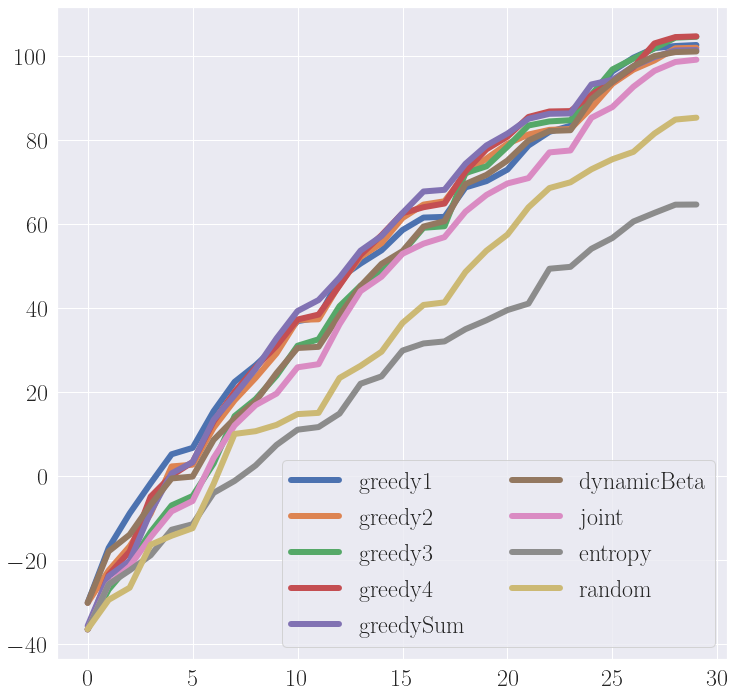

In [188]:
plt.figure(figsize=(12, 12))

plt.plot(greedy_IG_sum_trail_1, label='greedy1')
plt.plot(greedy_IG_sum_trail_2, label='greedy2')
plt.plot(greedy_IG_sum_trail_3, label='greedy3')
plt.plot(greedy_IG_sum_trail_4, label='greedy4')
plt.plot(greedy_IGsum_sum_trail, label='greedySum')
plt.plot(dynamic_beta_sum_trail, label='dynamicBeta')

plt.plot(joint_IG_sum_trail, label='joint')
plt.plot(entropy_IG_sum_trail, label='entropy')
plt.plot(rand_IG_sum_trail, label='random')

# plt.legend(loc='lower center', ncol=2)
plt.legend(ncol=2)
plt.show()

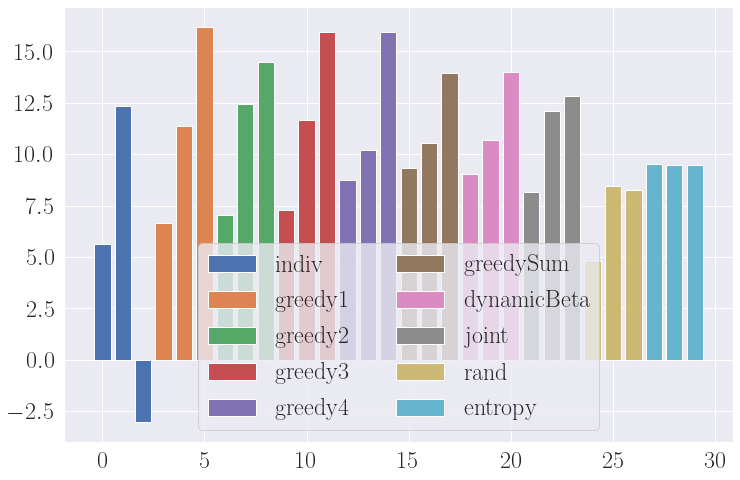

In [189]:
plt.figure(figsize=(12, 8))

pos = 0

ind_IG_sep_last = [ind_greedy_IG_trails[i][-1] for i in range(n)]
plt.bar(np.arange(n) + pos*n, ind_IG_sep_last, label='indiv')
pos += 1

for i, IG_sep_trail in enumerate([greedy_IG_sep_trail_1, greedy_IG_sep_trail_2, greedy_IG_sep_trail_3, greedy_IG_sep_trail_4]):
    plt.bar(np.arange(n)+pos*n, IG_sep_trail[-1], label='greedy'+str(i+1))
    pos += 1

for IG_sep_trail, name in zip([greedy_IGsum_sep_trail, dynamic_beta_sep_trail, joint_IG_sep_trail, entropy_IG_sep_trail, rand_IG_sep_trail], 
                              ['greedySum', 'dynamicBeta', 'joint','rand','entropy']):
    plt.bar(np.arange(n)+pos*n, IG_sep_trail[-1], label=name)
    pos+=1
    

plt.legend(loc='lower center', ncol=2)
plt.show()

### Plot trajectories of training individually

### Plot trajectories of CAL